In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


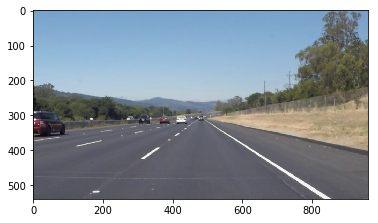

In [24]:
img = mpimg.imread('test_images/solidWhiteRight.jpg')

print('This image is:', type(img), 'with dimensions:', img.shape)
plt.imshow(img)

In [25]:
# Nessesary variables

kernel_size = 7         # Size of the n x n matrix used as kernel in gaussian blur

α = 0.9                 # Weight factor for initial image
β = 0.4                 # Weight factor for new image
λ = 0.22                # Scalar added to each sum (of new and initial image), see weighted_img function

low_threshold = 50      # Value for the canny function, defining the first threshold
high_threshold = 150    # Value for the canny function, defining the second threshold

rho = 1                 # Distance resolution in pixels of the Hough grid
theta = np.pi/90        # Angular resolution in radians of the Hough grid
threshold = 15          # Minimum number of votes (intersections in Hough grid cell)

min_line_length = 70    # Minimum number of pixels in a line
max_line_gap = 180      # Maximum gap in pixels between connectable line segments

H = img.shape[0]        # Getting the hight of the image
W = img.shape[1]        # Getting the width of the image

vertices = np.array([(x * W, y * H) for (x,y) in [[0.05,1], [0.46, 0.60], [0.54, 0.60], [1,1]]], np.int32) # ROI

In [26]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines


def weighted_img(img, initial_img, α=0.8, β=1.0, γ=0.0):
    return cv2.addWeighted(initial_img, α, img, β, γ)


def sort_lanes(lines):
    left_lines = []
    right_lines = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            # compute the line slope
            try:
                m = (y2 - y1)/(x2 - x1)
            except ZeroDivisionError:
                m = float('inf')
            
            # line equation is y = m * x + b
            b = y1 - (m * x1) 
            
            # left line
            if m < 0: 
                left_lines.append((m,b)) 
            # right line    
            if m > 0: 
                right_lines.append((m,b))
            
    return left_lines, right_lines


def draw_lines(img, lines, color=[255, 0, 0], thickness=7, cap=None):
    """
    Takes an img and a few lines that were recognized by Hough Transformation,
    reduces those lines to two average lines (caps those lines at the y
    pixel value "cap") and draws them with color "color" and thickness
    "thickness".
    """
    cap =  0.6*img.shape[0]
    
    if cap is None:
        cap = 1/2*img.shape[0]
    # ... by passing the lines through a polyfit_lines function that
    # reduces the lines to two lines: one right and one left line
    poly_lines = polyfit_lines(lines, img.shape[0], img.shape[1], cap)
    for x1,y1,x2,y2 in poly_lines:
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def polyfit_lines(lines, height, width, cap):
    """
    Helper function that takes a list of lines (line segments and reduces them to 
    two average lane lines by taking into consideration the height, width and
    estimated horizon (cap) of the image
    """
    # xs/ys contains all sampled x and y values of line segments
    # index 0 are all values of line segments identified as belonging 
    # to the left lane line, 1 is for right side. 
    xs = [[], []]
    ys = [[], []]
    result = [] # will be returned
    # iterate through line segments
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1))
            side = 0 if slope < 0 else 1
            if (side == 0):
                # Discard left line segment if 
                # slope is <22.5 deg raising or >67.5 deg falling
                # or not on left side of image
                if np.arctan(slope) > -1/8.*np.pi or np.arctan(slope) < -3/8.*np.pi or x1 > 0.5*width or x2 > 0.5*width:
                    continue
            else:
                # Discard right line segment if 
                # slope is <22.5 deg falling or > 67.5 deg falling
                # or not on right side of image
                if np.arctan(slope) < 1/8.*np.pi or np.arctan(slope) > 3/8.*np.pi or x1 < 0.5*width or x2 < 0.5*width:
                    continue
            # Sample pixels of line segment, one (x,y) point for 
            # each integer x value
            for x in range(x1,x2, 1 if x2>x1 else -1):
                xs[side].append(x)
                ys[side].append(y1+slope*(x-x1))
    # For each side (left & right)
    for xs_side,ys_side in zip(xs, ys):
        # If there is more than one point (shouldn't really 
        # happen - a one-point line shouldn't come from
        # hough transform)
        if len(xs_side) > 1 or len(ys_side) > 1:
            # Fit a line through all the points
            coeff = np.polyfit(xs_side, ys_side, 1)
            # Get slope (m) and y-intersect (b)
            m = coeff[0]
            b = coeff[1]
            # Calculate start- and end-point
            y1 = height # lower bound on bottom of image
            y2 = cap    # higher bound at horizon
            # x values can be inferred from that 
            x1 = (y1-b)/float(m)
            x2 = (y2-b)/float(m)
            result.append((int(x1),int(y1),int(x2),int(y2)))
    return result

# Below function did not work

def average_lines(img_height, lines):
    if len(lines) == 0:
        return []
    else:
        centerxs = [[], []]
        centerys = [[], []]
        slopes   = [[], []]
        tops     = [[], []]
        for line in lines:
            for (x1,y1,x2,y2) in line:
                slope = ((y2-y1)/(x2-x1))
                side = 0 if slope < 0 else 1
                slopes[side].append( slope )
                centerxs[side].append( (x2+x1)/2 )
                centerys[side].append( (y2+y1)/2 )
                tops[side].append( min(y1,y2) )
        result = []
        for side in [0, 1]:
            if len(tops[side]) == 0:
                continue
            top = min(tops[side])
            centerx = np.median(centerxs[side])
            centery = np.median(centerys[side])
            slope   = np.median(slopes[side])
            result.append([(
                    int(centery-(centery-top)/float(slope)),
                    int(top),
                    int(centery+(img_height-centery)/float(slope)),
                    int(img_height)
                )])
        return result        

In [27]:
def process_image(img):
    gray_img = grayscale(img)
    blur_img = gaussian_blur(gray_img, kernel_size)
    edge_img = canny(blur_img, low_threshold, high_threshold)
    maskd_img = region_of_interest(edge_img, [vertices])
    
    lines = hough_lines(maskd_img, rho, theta, threshold, min_line_length, max_line_gap)
    
    # draw lines
    
    lane_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(lane_img, lines)
    
    final_img = weighted_img(lane_img, img, α, β, λ)
    
    return final_img

## Process image

Image solidWhiteCurve.jpg displayed below is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


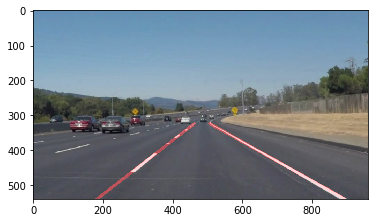

Image whiteCarLaneSwitch.jpg displayed below is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


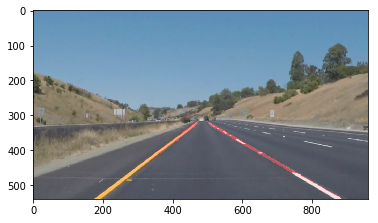

Image solidWhiteRight.jpg displayed below is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


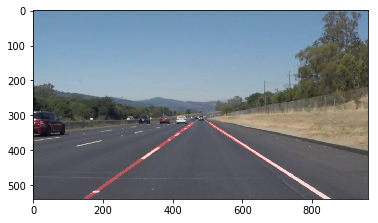

Image solidYellowCurve.jpg displayed below is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


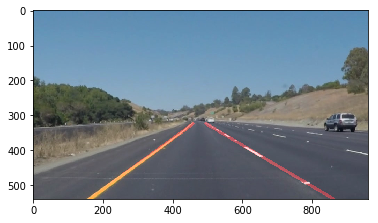

Image solidYellowCurve2.jpg displayed below is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


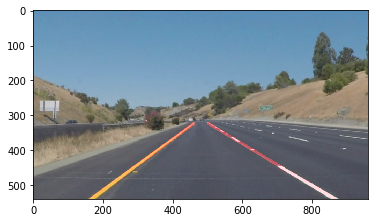

Image solidYellowLeft.jpg displayed below is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


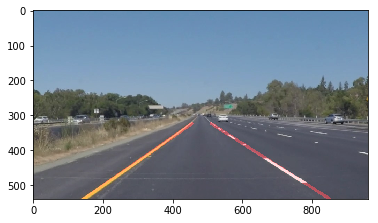

In [28]:
for image_file in os.listdir("test_images/"):
    img = mpimg.imread("test_images/" + image_file)
    processed_img = process_image(img)
    
    # save pic
    mpimg.imsave('test_images_output/Processed_'+ image_file, processed_img)
    
    print('Image ' + image_file +' displayed below is:', type(img), 'with dimensions:', img.shape)
    plt.imshow(processed_img)
    plt.show()

## Process video 

In [29]:
white_output = 'test_videos_output/solidWhiteRight2.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight2.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight2.mp4


100%|█████████▉| 221/222 [00:14<00:00, 13.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight2.mp4 



In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft2.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft2.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft2.mp4


100%|█████████▉| 681/682 [00:50<00:00, 13.49it/s]
